Training set: (90, 100, 100, 3), Labels: (90, 6)
Testing set: (30, 100, 100, 3), Labels: (30, 6)


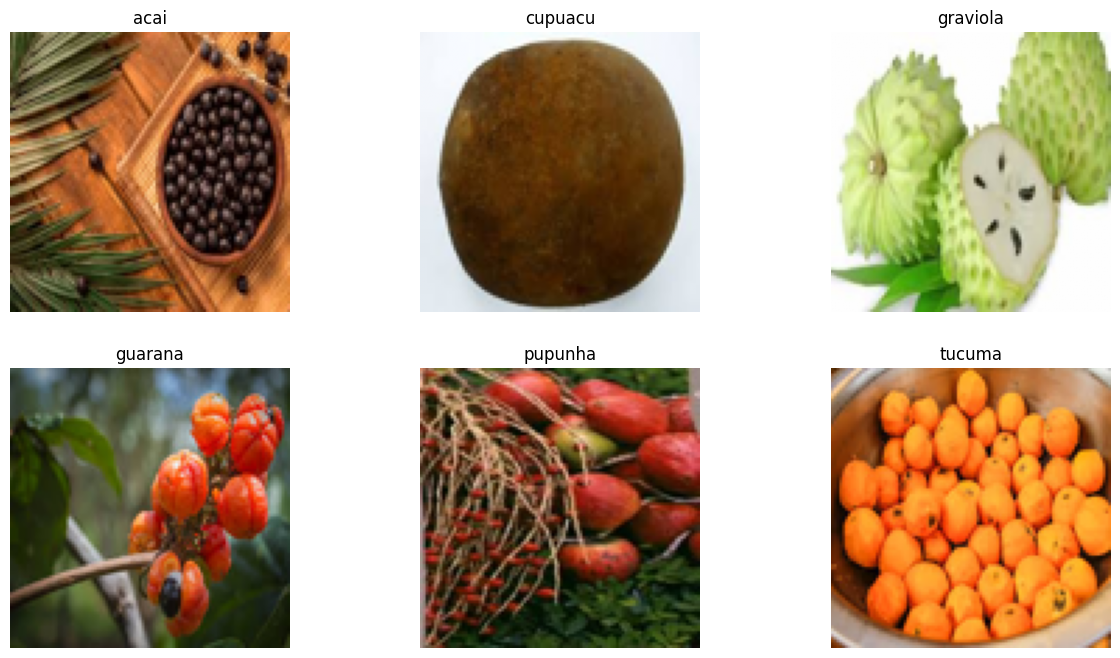

In [ ]:
!pip install Pillow
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import random

# Get the current working directory
current_directory = os.getcwd()

# Construct the path to the zip file
zip_file_path = os.path.join(current_directory, 'FruitinAmazon.zip')

# Define the directory to extract to
directory_to_extract_to = current_directory

# Check if the file exists before attempting to open it
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
else:
    print(f"Error: The zip file '{zip_file_path}' was not found.")

# Define dataset paths
train_dir = os.path.join(directory_to_extract_to, 'FruitinAmazon', 'train')
test_dir = os.path.join(directory_to_extract_to, 'FruitinAmazon', 'test')

# Function to load images and labels using PIL
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))
    class_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = Image.open(img_path).convert("RGB")
            # Resize the image to a consistent size
            img = img.resize((100, 100), 3)  # Example size: 100x100
            img = np.array(img) / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load the datasets and get class names
x_train, y_train, train_class_names = load_images_from_folder(train_dir)
x_test, y_test, test_class_names = load_images_from_folder(test_dir)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")

# Visualize one random image from each class
num_classes = len(train_class_names)
plt.figure(figsize=(15, 8))  # Adjust figure size if needed

for class_index in range(num_classes):
    # Find indices of images belonging to the current class
    indices_of_class = np.where(np.argmax(y_train, axis=1) == class_index)[0]

    # Select a random image from the current class
    random_image_index = random.choice(indices_of_class)

    # Display the image
    plt.subplot(2, 3, class_index + 1)  # Adjust subplot grid if needed
    plt.imshow(x_train[random_image_index])
    class_name = train_class_names[class_index]
    plt.title(f"{class_name}")
    plt.axis("off")

plt.show()

In [ ]:
# prompt: Check for Corrupted Image: Write a script that verifies whether the image in the train
# directory are valid. If any corrupted images are found, the script must remove the image from
# the directory and print the message which image have been removed, if none found print ”No
# Corrupted Images Found.”
# • Hint:
# – Iterate through each class subdirectory and check if each image is valid.
# – Use the Image.open() function to attempt to load each image.
# – If the image is corrupted i.e. raises an IOError or SyntaxError, remove the image from
# the directory and print f"Removed corrupted image: {image_path}".
# – Maintain a list of all corrupted image paths for reporting.
# • Expected Output: No corrupted images found.

import os
from PIL import Image

def check_for_corrupted_images(directory):
    """
    Checks for and removes corrupted images from a directory.
    """
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            image_path = os.path.join(root, file)
            try:
                img = Image.open(image_path)
                img.verify()  # Verify the image data
                img.close()  # Close the image file
            except (IOError, SyntaxError) as e:
                print(f"Removed corrupted image: {image_path}")
                corrupted_images.append(image_path)
                try:
                    os.remove(image_path)  # Remove corrupted image
                except OSError as e:
                    print(f"Error removing file {image_path}: {e}")

    if not corrupted_images:
        print("No Corrupted Images Found.")

# Example usage (assuming 'train_dir' is defined as in your code):
check_for_corrupted_images(train_dir)


No Corrupted Images Found.


In [ ]:
import tensorflow as tf
# Define image size and batch size
img_height = 100 # Example image height
img_width = 100 # Example image width
batch_size = 32
validation_split = 0.2 # 80% training, 20% validation
# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)
# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
# Load a sample dataset (MNIST for simplicity)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Normalize and reshape data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1) # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)
# Define a simple CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation="relu", input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation="relu"),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
]

# Train the model
history = model.fit(train_ds,
          epochs=250,
          batch_size=16,
          callbacks=callbacks,
          validation_data=val_ds
          )
model.summary()

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 855ms/step - accuracy: 0.1762 - loss: 1.9587 - val_accuracy: 0.0000e+00 - val_loss: 2.1271
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 558ms/step - accuracy: 0.1723 - loss: 1.8232 - val_accuracy: 0.0000e+00 - val_loss: 1.9166
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 539ms/step - accuracy: 0.3203 - loss: 1.7274 - val_accuracy: 0.0000e+00 - val_loss: 1.8615
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 749ms/step - accuracy: 0.4744 - loss: 1.6361 - val_accuracy: 0.0000e+00 - val_loss: 1.8185
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - accuracy: 0.4054 - loss: 1.5318 - val_accuracy: 0.3889 - val_loss: 1.5908
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - accuracy: 0.5707 - loss: 1.3725 - val_accuracy: 0.2778 - val_loss: 1.4893
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.5777 - loss: 1.1692 - val_accuracy: 0.6667 - val_loss: 1.2205
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.7834 - loss: 0.9493 - val_accu

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,280,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,897,908 (14.87 MB)

 Trainable params: 1,299,302 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,598,606 (9.91 MB)

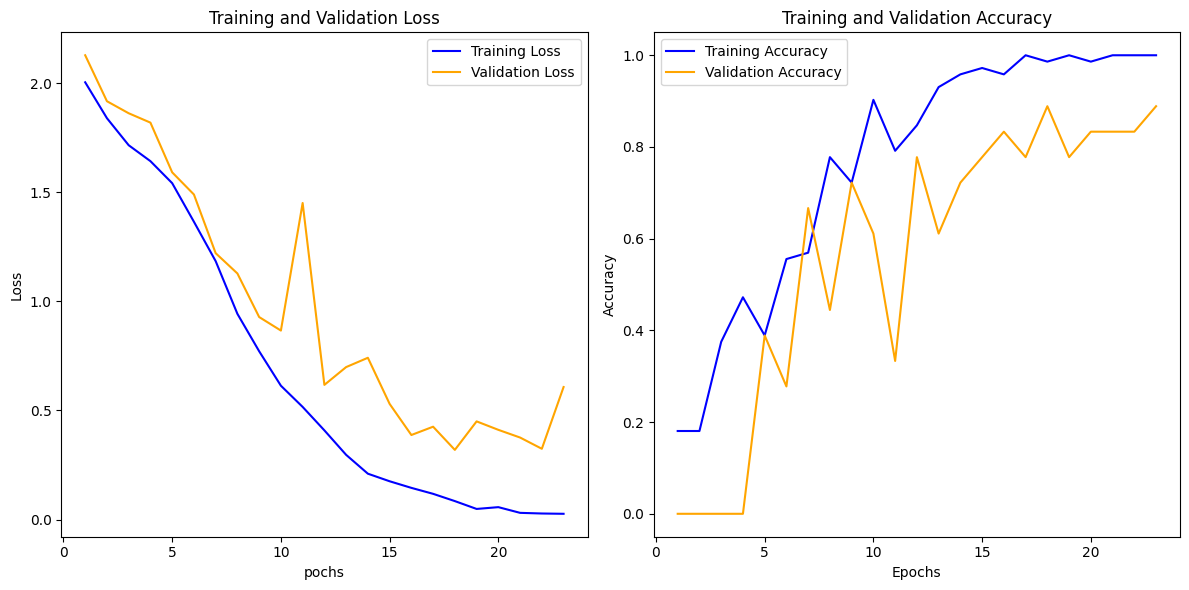

In [ ]:
import matplotlib.pyplot as plt
# Assuming ’history’ is the object returned by model.fit()
# Extracting training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# Extracting training and validation accuracy (if metrics were specified)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('pochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(train_ds, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

3/3 - 0s - 163ms/step - accuracy: 0.9444 - loss: 0.1282
Test accuracy: 0.9444


In [ ]:
model.save('mnist_fully_connected_model.h5')
loaded_model = tf.keras.models.load_model('mnist_fully_connected_model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('mnist_fully_connected_model.h5')

In [ ]:

# Get the number of classes from the loaded model
# Use output.shape instead of output_shape
num_classes_model = loaded_model.layers[-1].output.shape[-1]  # Get from the output layer

# Create test dataset with the correct number of classes
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Use 'categorical' if your labels are one-hot encoded
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)

# Get the class names before applying .map()
num_classes_dataset = len(test_ds.class_names)  # Get class names here

# Apply the normalization (Rescaling) to the dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))


# Check if the number of classes in the model and dataset match
# num_classes_dataset = len(test_ds.class_names)  <- Remove this line
# This works when `label_mode='int'`
# If `label_mode='categorical'`, then you should get the number of classes from the shape of y in the dataset.
if num_classes_model != num_classes_dataset:
    print(f"Warning: Model expects {num_classes_model} classes, but dataset has {num_classes_dataset} classes.")
    print("This might cause issues during evaluation.")
    # Potentially adjust the model or dataset to match the number of classes


# Evaluate the loaded model using the test set
test_loss, test_acc = loaded_model.evaluate(test_ds, verbose=2)
print(f"\nTest accuracy (loaded model): {test_acc:.4f}")

Found 30 files belonging to 6 classes.
1/1 - 0s - 189ms/step - accuracy: 0.6333 - loss: 1.7996

Test accuracy (loaded model): 0.6333


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Found 30 files belonging to 6 classes.


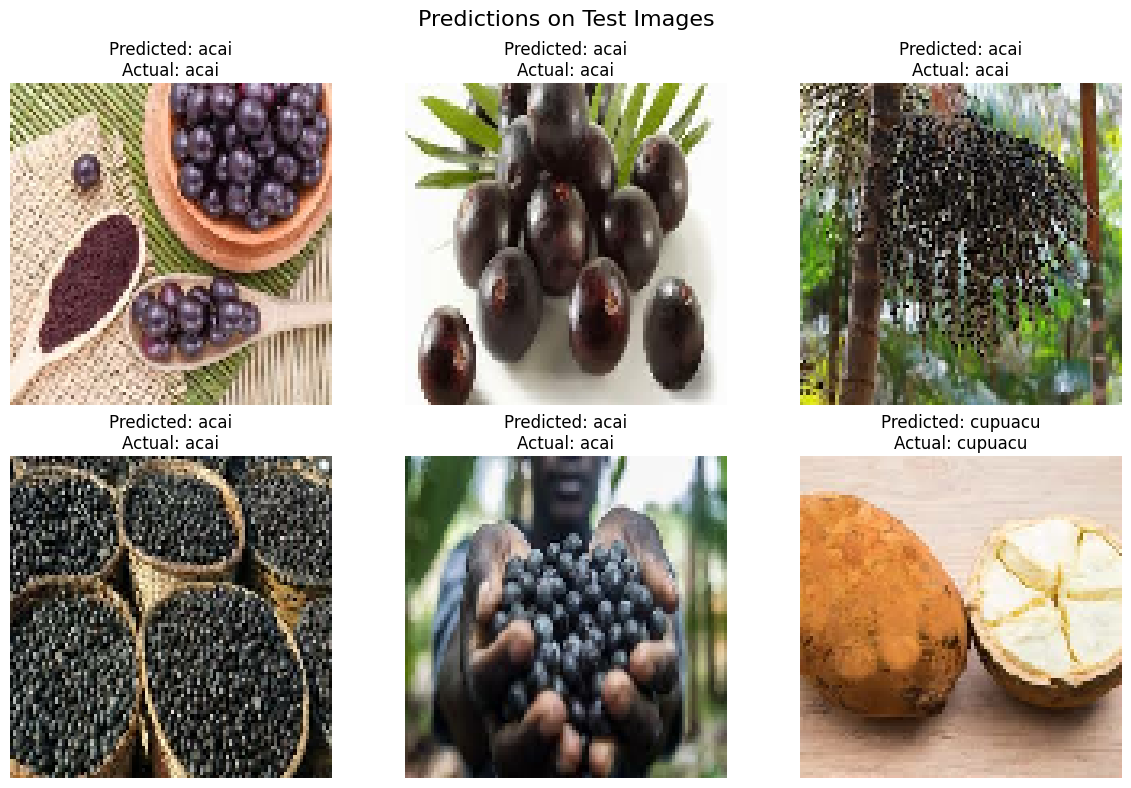

              precision    recall  f1-score   support

        acai       0.56      1.00      0.71         5
     cupuacu       1.00      0.80      0.89         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.00      0.00      0.00         5
      tucuma       0.30      0.60      0.40         5

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.60        30
weighted avg       0.64      0.63      0.60        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
# Make predictions and display results
predictions = loaded_model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get images and labels from test_ds
test_images = []
test_labels_actual = []
for images, labels in test_ds.as_numpy_iterator():
    test_images.extend(images)
    test_labels_actual.extend(labels)
test_images = np.array(test_images)
test_labels_actual = np.array(test_labels_actual)

# Get the class names before applying .map()
# This will ensure class_names are available
class_names = loaded_model.layers[-1].output.shape[-1]  # Get class names here

# Create test dataset with the correct number of classes
test_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',  # Use 'categorical' if your labels are one-hot encoded
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)

class_names = test_ds_new.class_names  # Access class names directly


# Display the first 6 images with predictions and actual labels in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Predictions on Test Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(test_images):
        ax.imshow(test_images[i])
        predicted_label = predicted_labels[i]
        actual_label = test_labels_actual[i]

        # Use the class_names variable obtained earlier
        predicted_fruit_name = class_names[predicted_label]
        actual_fruit_name = class_names[actual_label]

        ax.set_title(f"Predicted: {predicted_fruit_name}\nActual: {actual_fruit_name}")
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()

# Generate classification report
# Use the class_names variable obtained earlier
from sklearn.metrics import classification_report
print(classification_report(test_labels_actual, predicted_labels, target_names=class_names))